In [6]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd 
import pygrib 
import metpy
plt.style.use("ggplot")
from metpy import calc as mcal
from metpy.units import units

In [310]:
p=np.arange(1000,299,-1)
t=np.arange(120,-50,-1)
pp,tt=np.meshgrid(p,t)
press=units.Quantity(np.arange(1000,299,-50),"hPa")
temperature=units.Quantity(np.arange(120,-50,-1),"degC")
temperature2=units.Quantity(np.arange(230,400.1,10),"K")


In [311]:
#湿潤断熱線
moist=mcal.moist_lapse(pressure=press,temperature=temperature2[:,np.newaxis])
#乾燥断熱線
dry=mcal.dry_lapse(pressure=press,temperature=temperature2[:,np.newaxis])
## 飽和水蒸気圧
## tetens(1930)の式より
def e_saturation(Tcel):
    T=Tcel#ここセルシウス温度
    ganma=(7.50*T)/(T+237.3)
    e=6.1078*10**(ganma)
    return e
def w_saturation(Pd,Tcel):
    w_s=0.622*e_saturation(Tcel)/(Pd-e_saturation(Tcel))
    return w_s*1e3
## 露点温度
ws=w_saturation(pp,tt)

## MSM

In [194]:
file="/home/takato/E/MSM/Z__C_RJTD_20210501090000_MSM_GPV_Rjp_L-pall_FH00-15_grib2.bin"
msm=pygrib.open(file)
temp=msm.select(name="Temperature")
rh=msm.select(name="Relative humidity")

In [334]:
tprofile=np.zeros(16)
rhprofile=np.zeros_like(tprofile)
dewprofile=np.zeros_like(tprofile)
msm_press=[1000,975,950,925,900,850,800,700,600,500,400,300,250,200,150,100]
for i in range(0,16):
    tprofile[i]=temp[i].values[100,100]
    rhprofile[i]=rh[i].values[100,100]
met_t=units.Quantity(tprofile,units="K").to("degC")
met_rh=units.Quantity(rhprofile,units="%")
met_dew=mcal.dewpoint_from_relative_humidity(met_t,met_rh)


Text(0.5, 1.0, 'Emagram')

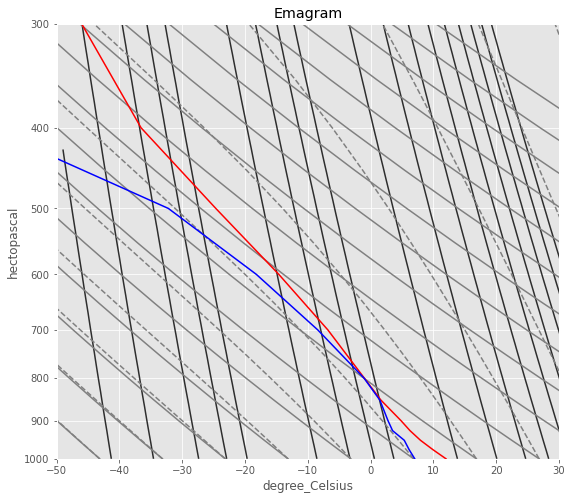

In [343]:
fig,ax=plt.subplots(figsize=(9,8),facecolor="w")
p=np.arange(1000,299,-50)

#断熱線
for i in range(temperature2.size):
    ax.plot(moist[i,:].to("degC"),press,linestyle="--",c="gray")
    ax.plot(dry[i,:].to("degC"),press,c="gray")
#等飽和混合比線
cf=ax.contour(tt,pp,ws,levels=[0.01,0.1,0.2,0.4,0.6,0.8,2,3,4,5,10,15,20,25,30,35,40,45,50],extend="both",alpha=0.8,colors="k")
#MSMの気温鉛直プロファイル
ax.plot(met_t,msm_press,c="r")
ax.plot(met_dew,msm_press,c="b")
#
ax.set_ylim(300,1000)
ax.invert_yaxis()
#ax.set_yscale("function",functions=(forward,inverse))
ax.set_yscale("log")
ax.set_xlim(-50,30)
ax.yaxis.set_major_locator(plt.FixedLocator(np.arange(300,1001,100)))
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_title("Emagram")